# Econoimcs 142 

#Estimating Productivity Using OLS Regression/Panel Regression/Proxy Variable Regression
#Jiwon Son

In [911]:
# Load core data science libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

#1.1 Preparing the dataset
# Read in tab-delimited dataset into a pandas dataframe
col_dtypes = {"gvkey" : int, "year" : int, "Y" : float, "K" : float, "L" : float, "M" : float , "VA" : float, "i" : float, "naics_4digit" : int}

df = pd.read_csv("/Users/davidson/.spyder-py3/mf_firms.out.txt", dtype = col_dtypes, na_values="", engine="c", sep = "\t", encoding = "utf−8")
df.drop(['gvkey.1','year.1'],axis=1, inplace=True)

In [912]:
# Obtain distinct values from the dataframe column 'year'
years = df['year'].unique()

# Convert'year' column to string data type and add it as a new dataframe column.
df['year_str'] = df['year'].astype(str)

# Keep only last two digits of year
df['year_str'] = df['year_str'].str[-2:]

# Generate indicator variable that takes value 1 if the last two digits of year is 13 or 14 and 0 otherwise.
indicator_13_14 = df['year_str'].isin(['13','14'])

# Extract observations corresponding to years 2013 and 2014
df_13_14 = df[indicator_13_14]

# Generate indicator variable that takes value 1 if 'year' is equal to 2013 or 2014 and value 0 otherwise.
new_indicator_13_14 = (df['year']==2013)|(df['year']==2014)

# Check if the previous indicator variable and the new indicator variable are equal
check_equal = (indicator_13_14)==(new_indicator_13_14)
# Each row of the above variable takes value 1 if the corresponding rows of the two indicators are equal and takes
# value zero otherwise. We want to ensure that each row of check_equal has value 1. That is, the sum of check_euqal
# is equal to the total number of observations.
print(sum(check_equal)==len(df))

True


In [913]:
# Construct indicator variable that takes value 1 if 'year' is equal to 2013 and 0 otherwise.
indicator_13 = (df['year']==2013)

# Construct dataset corresponding to year 2013
df_13 = df[indicator_13]

# Construct indicator variable that takes value 1 if 'year' is equal to 2014 and 0 otherwise.
indicator_14 = (df['year']==2014)

# Construct dataset corresponding to year 2014
df_14 = df[indicator_14]

# Extact distinct firm ids from 2013
firms_13 = df_13['gvkey'].unique()
# Convert to set object
firms_13 = set(firms_13)

# Extract distinct firm ids form 2013
firms_14 = df_14['gvkey'].unique()
# Conver to set object
firms_14 = set(firms_14)

# Sort each by firm id to ensure that the data rows are matched by firm id
df_13.sort_values(by=['gvkey'])
df_14.sort_values(by=['gvkey'])

df_13 = df_13[df_13['gvkey'].isin(df_14['gvkey'])]
df_14 = df_14[df_14['gvkey'].isin(df_13['gvkey'])]

# Reset row indices
df_13 = df_13.reset_index()
df_14 = df_14.reset_index()


print('First 3 observations from 2013 Dataset')
print(df_13.head(3))
print('\n')
print('First 3 observations from 2014 Dataset')
print(df_14.head(3))
print('\n')
print(len(df_13)==len(df_14))

First 3 observations from 2013 Dataset
   index  gvkey  year             Y             K       L             M  \
0     46   1050  2013    184.918233     16.236777   0.783    116.049983   
1     70   1072  2013   1585.233591   1971.243363  10.800    577.475328   
2     84   1078  2013  18269.697122  18833.963822  69.000  11070.662118   

            VA            i  naics_4digit year_str  
0    68.868250     1.296683          3334       13  
1  1007.758263    46.177310          3344       13  
2  7199.035004  1062.004359          3254       13  


First 3 observations from 2014 Dataset
   index  gvkey  year             Y             K       L            M  \
0     47   1050  2014    242.782036     34.842984   0.853   160.397790   
1     71   1072  2014   1444.400192   2033.063657  10.700   558.888923   
2     85   1078  2014  16812.535291  12870.000000  77.000  9070.023583   

            VA           i  naics_4digit year_str  
0    82.384246    1.065701          3334       14  
1   88

In [914]:
#1.1
firm_year_obs = 29836 #firm_year_obs
print("We have %d firm-year observations." %firm_year_obs)

print('\n')

print("How many distinct firms?")
# Obtain firms ids that appear in both 2013 and 2014. This is the intersection of the two sets above.
firms_13_14 = firms_14.intersection(firms_13)
print('There are %d firms that appear in both 2013 and 2014.' %len(firms_13_14))

print('\n')

df14 = df[df['year']==2014]

print("Aggregate total sales across all manufacturing firms in 2014")
numsum = sum(df14.Y)
print(numsum) 
print('million USD')

print('\n')

numsum1 = sum(df14.L)
print("How many workers did these firms employ in total?")
print(1000*numsum1)

#Disply information in a Table
df14['L'] = df14['L']*1000

df14[['Y','K','L','M','i']].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])

We have 29836 firm-year observations.


How many distinct firms?
There are 1270 firms that appear in both 2013 and 2014.


Aggregate total sales across all manufacturing firms in 2014
4598885.16562
million USD


How many workers did these firms employ in total?
10561921.0


/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Y,K,L,M,i
count,1385.000000,1385.000000,1385.000000,1385.000000,1385.000000
mean,3320.494704,2231.672204,7625.935740,2322.643726,177.861325
std,13757.130624,17611.446735,21993.220681,10755.259635,1339.764645
min,0.015777,0.043616,11.000000,0.076002,0.000000
5%,2.381021,1.307091,31.000000,6.797117,0.064936
25%,39.397880,14.930594,152.000000,37.964972,1.025990
50%,335.954781,125.984336,994.000000,211.207990,10.953641
75%,1824.290514,856.879813,5607.000000,1162.113794,63.954279
95%,13011.277576,6869.959647,34968.000000,8127.425641,542.736655
max,259274.554682,525470.728374,302000.000000,219383.525866,32894.516806


1.1Q: Write a few sentences summarizing dataset.

A: This table shows descriptive statistics of total sales, capital stock, employees, materials, and investment across all manufacturing firms in 2014 in my dataset. For each variable, the mean is greater than the median, so each variable has a right-skewed distribution, so each variable has an outlier on the far right side, as can be seen in the maximum value of each variable, and also in how much they deviate from 95% value. This might suggest that the manufacturing industry heavily depends on the "outlier" large firms.

In [915]:
#1.2 OLS production function estimates

#same df1 from above--for 2014 only
df14['logY14'] =np.log(df14["Y"])
df14['logK14'] =np.log(df14["K"])
df14['logL14'] =np.log(df14["L"])
df14['logM14'] =np.log(df14["M"])

Y = df14["logY14"]
X = df14[["logK14","logL14","logM14"]]
X = sm.add_constant(X) #Add aconstant term to the predictor
# OLS regression
ols = sm.OLS(Y,X).fit(cov_type='HC0') #Heteroscedastic robust standard errors
ols.summary()

/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logY14   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     3987.
Date:                Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:14:20   Log-Likelihood:                -1659.1
No. Observations:                1385   AIC:                             3326.
Df Residuals:                    1381   BIC:                             3347.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3562      0.111    -12.206      0.000      -1.574      -1.138
logK14         0.1589      0.029      5.504      0.000       0.102       0.215
logL14         0.4859      0.031     15.575      0.000       0.425       0.547
logM14         0.5132      0.035     14.524      0.000       0.444       0.582
==============================================================================
Omnibus:                      888.611   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11588.718
Skew:                          -2.817   Prob(JB):                         0.00
Kurtosis:                      16.003   Cond. No.                         47.4
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [942]:
#Coefficient vector and Covariance Matrix
coef1 = ols.params
cov1 = ols.cov_params()

#var = np.diag(cov1) # Obtain diagonal elements of cov

print (coef1)
print ('\n')
print (cov1)
print ('\n')

#Hyptohesis Testing
t = (sum(ols.params[1:4])-1)/(sum(np.diag(cov1))-cov1['const'][0]+2*(cov1['logL14'][1]+cov1['logM14'][1]+cov1['logM14'][2]))**(0.5)
print(t)
hypotheses = 'logK14+logL14+logM14=1'
t_test = ols.t_test(hypotheses)
print(t_test)
print("we can reject the null hypothesis under 95% significance level.")

const    -1.356232
logK14    0.158893
logL14    0.485932
logM14    0.513235
dtype: float64


           const    logK14    logL14    logM14
const   0.012347  0.000759 -0.002776  0.000900
logK14  0.000759  0.000833 -0.000200 -0.000656
logL14 -0.002776 -0.000200  0.000973 -0.000608
logM14  0.000900 -0.000656 -0.000608  0.001249


14.0297113153
                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.1581      0.011     14.030      0.000       1.136       1.180
we can reject the null hypothesis under 95% significance level.


1.2Q: Briefly Comment on your results. Can you reject the null hpyothesis on constant returns to scale? Do you believe your coefficient estimates are consistent for the underlying output elasticities? Why?

A: When the product function is given as $Y=AK^{\alpha}L^{\beta}M^{\gamma}$, we are estimating the elasticity of output with respect to capital, labor, and material expenditures using a simple OLS regression. When we take the log of each side of the function, then we have the following expression: $log(Y)=log(A)+\alpha log(K)+\beta log(L)+\gamma log(M)$ = $E[log(A)]+log(A)+\alpha log(K)+\beta log(L)+\gamma log(M)+\epsilon$ , where A is the unobservable productivity of the firm, and the error is  $\epsilon = log(A)-E[log(A)]$.
Then, our estimating function will have this OLS estimation of projection of form $E^{*}[log(Y)|log(K),log(L),log(M)]$, and our coefficients will be the estimates for elasticities of output in the sample. The sum of $\hat{\alpha}$,$\hat{\beta}$, and $\hat{\gamma}$ will give us information about returns to scale. if the sum is equal to one we will have constant returns to scale.
Our estimated coefficients for the elasticity of output with respect to capital, labor, and material expenditures are 0.1589, 0.4859, and 0.5132, respectively. Here, $\alpha = 0.1589$ means 0.1589% changes in Y is induced by 1% change in K, holding other variables constant. Under the null hypothesis of ${\alpha}+{\beta}+{\gamma}=1$, we get a test statistic approximately equal to 14.03, much higher than 1.96 of 95% confidence interval. Thus, we cannot reject the null hyptoehsis of constant returns to scale under this significance level 0.05.
The error term here $\epsilon = log(A)-E[log(A)]$ has a mean of zero and is likely to lead to unbiased estimators for the underlying output elasticities. However, we still have to ask if there is endogeneity bias that might happen when regressor variables are correlated with error terms. But it is doubtful that each input demand of log capital, log labor, and log materials is uncorrleated with the error term $\epsilon = log(A)-E[log(A)]$, or simply with log productivity. Thus, It might be hard to believe that the coefficient estimates are consistent.

In [917]:
#1.2 OLS with dummy variables

Y = df14["logY14"]
X = df14[["logK14","logL14","logM14"]]
X = sm.add_constant(X) #Add aconstant term to the predictor

# Construct a list of all naics_4digit in the dataset
included_4digit = sorted (df14['naics_4digit'].unique ())
# Form dummies for each of naics_4digit
pair_dums = pd.get_dummies(df14['naics_4digit'].astype("category"), prefix="n4")
# Concatenate matched pair dummies onto dataframe 
df14 = pd. concat ([ df14 , pair_dums ] , axis=1)

X = pd.concat([X, pair_dums.iloc[:,0:-1]], axis=1)
#OLS regression with dummy variables
ols2 = sm.OLS(Y,X).fit(cov_type="HC0")
ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 logY14   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.917
Method:                 Least Squares   F-statistic:                 8.679e+15
Date:                Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:14:20   Log-Likelihood:                -1571.7
No. Observations:                1385   AIC:                             3307.
Df Residuals:                    1303   BIC:                             3737.
Df Model:                          81                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2037      0.161     -7.490      0.000      -1.519      -0.889
logK14         0.1405      0.032      4.412      0.000       0.078       0.203
logL14         0.4528      0.035     12.986      0.000       0.384       0.521
logM14         0.5388      0.036     14.826      0.000       0.468       0.610
n4_3111       -0.0801      0.110     -0.731      0.465      -0.295       0.135
n4_3112        0.0167      0.157      0.106      0.916      -0.291       0.325
n4_3113        0.1755      0.196      0.897      0.370      -0.208       0.559
n4_3114        0.1271      0.136      0.936      0.349      -0.139       0.393
n4_3115        0.3641      0.193      1.889      0.059      -0.014       0.742
n4_3116       -0.1595      0.133     -1.202      0.229      -0.419       0.100
n4_3118       -0.0988      0.114     -0.869      0.385      -0.322       0.124
n4_3119        0.0185      0.167      0.110      0.912      -0.310       0.347
n4_3121        0.3076      0.137      2.248      0.025       0.039       0.576
n4_3122        0.4875      0.182      2.682      0.007       0.131       0.844
n4_3131       -0.1640      0.121     -1.356      0.175      -0.401       0.073
n4_3132        0.2061      0.231      0.893      0.372      -0.246       0.659
n4_3141       -0.0107      0.163     -0.065      0.948      -0.331       0.309
n4_3151        0.1335      0.126      1.059      0.289      -0.114       0.380
n4_3152       -0.0324      0.122     -0.266      0.790      -0.271       0.206
n4_3159        0.4428      0.118      3.751      0.000       0.211       0.674
n4_3162        0.0377      0.124      0.303      0.762      -0.206       0.281
n4_3169        0.5013      0.313      1.602      0.109      -0.112       1.114
n4_3211       -0.3412      0.469     -0.728      0.467      -1.260       0.578
n4_3212        0.0671      0.153      0.439      0.660      -0.232       0.366
n4_3219        0.1345      0.124      1.083      0.279      -0.109       0.378
n4_3221       -0.0310      0.129     -0.240      0.811      -0.285       0.223
n4_3222       -0.1132      0.130     -0.868      0.385      -0.369       0.142
n4_3231        0.0114      0.130      0.088      0.930      -0.244       0.267
n4_3241        0.4693      0.157      2.988      0.003       0.162       0.777
n4_3251        0.1885      0.165      1.146      0.252      -0.134       0.511
n4_3252        0.0959      0.151      0.633      0.526      -0.201       0.393
n4_3253        0.2258      0.204      1.105      0.269      -0.175       0.626
n4_3254       -0.4723      0.135     -3.486      0.000      -0.738      -0.207
n4_3255        0.0970      0.167      0.579      0.562      -0.231       0.425
n4_3256        0.2204      0.143      1.544      0.123      -0.059       0.500
n4_3259       -0.1584      0.242     -0.656      0.512      -0.632       0.315
n4

In [953]:
#Coefficient vector and Covariance Matrix
coef2= ols2.params
cov2 = ols2.cov_params()

#Hyptohesis Testing
t = (sum(ols2.params[1:4])-1)/np.sqrt(cov2['logK14'][1]+cov2['logL14'][2]+cov2['logM14'][3]+2*(cov2['logL14'][1]+cov2['logM14'][1]+cov2['logM14'][2]))
#12.56
#sum(ols2.params[1:4])-1
t
hypotheses = 'logK14+logL14+logM14=1'
t_test = ols2.t_test(hypotheses)
print(t_test)
print("we can reject the null hypothesis under 95% significance level.")

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             1.1321      0.011     12.563      0.000       1.111       1.153
we can reject the null hypothesis under 95% significance level.


1.2Q: Briefly comment on your results. Can you reject the null hypothesis of constant returns to scale? Do you believe your coefficient estimates are consistent for the underlying ouptut elasticities? Why?

A: For the OLS with dummy variables included, our estimated coefficients for the elasticity of output with respect to capital ($\alpha$), labor ($\beta$), and material expenditures ($\gamma$) are 0.1405, 0.4528, and 0.5338, respectively.
Here, $\alpha = 0.1405$ means 0.1405% changes in Y is induced by 1% change in K, holding other variables constant.
By adding dummy variables specific to industry segment to the regression, we are fixing variables specific to the industry sector, possilby removing omitted variable bias. Under the null hypothesis of ${\alpha}+{\beta}+{\gamma}=1$, we get a test statistic approximately equal to 12.56, higher than 1.96 of 95% confidence interval. Thus, we can reject the null hyptoehsis of constant returns to scale at this significance level.
However, we still have to ask if there is endogeneity bias that might happen when regressor variables are correlated with error terms. Other than fixing variables that might bias the coefficients for the elasticity of output,it is still doubtful that each input demand of log capital, log labor, and log materials is uncorrleated with the error term, or with log productivity. Thus, adding dummies to simple OLS regression might not be enough to make the coefficient estimates consistent.


In [919]:
#1.3 Panel Production Function Estimates

df_13['logY13'] = np.log(df_13['Y'])
df_13['logK13'] = np.log(df_13['K'])
df_13['logL13'] =np.log(df_13['L'])
df_13['logM13'] =np.log(df_13['M'])

df_14['logY14'] = np.log(df_14['Y'])
df_14['logK14'] = np.log(df_14['K'])
df_14['logL14'] = np.log(df_14['L'])
df_14['logM14'] = np.log(df_14['M'])

df_13['constant'] =1
df_13['deltalogY'] = df_14.logY14-df_13.logY13
df_13['deltalogK'] = df_14.logK14-df_13.logK13
df_13['deltalogL'] = df_14.logL14-df_13.logL13
df_13['deltalogM'] = df_14.logM14-df_13.logM13
X1=df_13[['constant','deltalogK','deltalogL','deltalogM']]
#Panel Data Regression
ols3=sm.OLS(df_13.deltalogY,X1).fit(cov_type="HC0")
ols3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deltalogY   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     25.58
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           4.55e-16
Time:                        17:14:20   Log-Likelihood:                -654.15
No. Observations:                1270   AIC:                             1316.
Df Residuals:                    1266   BIC:                             1337.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0270      0.010      2.657      0.008       0.007       0.047
deltalogK     -0.0035      0.054     -0.065      0.948      -0.110       0.103
deltalogL      0.4212      0.134      3.148      0.002       0.159       0.683
deltalogM      0.5185      0.074      7.018      0.000       0.374       0.663
==============================================================================
Omnibus:                     1393.059   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289316.900
Skew:                           4.949   Prob(JB):                         0.00
Kurtosis:                      76.276   Cond. No.                         5.01
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [920]:
#1.3 Panel production function estimates -- another version

df2 = df[df["year"]>=2013]

df2['logY1314'] =np.log(df2["Y"])
df2['logK1314'] =np.log(df2["K"])
df2['logL1314'] =np.log(df2["L"])
df2['logM1314'] =np.log(df2["M"])

diff=df2.groupby(df2.gvkey).diff()
df2 =diff.dropna(how = "all")
df2['constant']=1

X1=df2[['constant','logK1314','logL1314','logM1314']]
#Panel Data Regression
ols3_1= sm.OLS(df2.logY1314,X1).fit(cov_type="HC0")
ols3_1.summary()

/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               logY1314   R-squared:                       0.202
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     25.58
Date:                Thu, 08 Mar 2018   Prob (F-statistic):           4.55e-16
Time:                        17:14:24   Log-Likelihood:                -654.15
No. Observations:                1270   AIC:                             1316.
Df Residuals:                    1266   BIC:                             1337.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0270      0.010      2.657      0.008       0.007       0.047
logK1314      -0.0035      0.054     -0.065      0.948      -0.110       0.103
logL1314       0.4212      0.134      3.148      0.002       0.159       0.683
logM1314       0.5185      0.074      7.018      0.000       0.374       0.663
==============================================================================
Omnibus:                     1393.059   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289316.900
Skew:                           4.949   Prob(JB):                         0.00
Kurtosis:                      76.276   Cond. No.                         5.01
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [946]:
#Coefficient vector and Covariance Matrix
coef3= ols3.params
cov3 = ols3.cov_params()

print (coef3)
print ('\n')
print (cov3)
print ('\n')

#Hyptohesis Testing
t = (sum(ols3.params[1:])-1)/np.sqrt(sum(np.diag(cov3))-cov3['constant'][0]+2*(cov3['deltalogL'][1]+cov3['deltalogM'][1]+cov3['deltalogM'][2]))
t
hypotheses = 'deltalogK+deltalogL+deltalogM=1'
t_test = ols3.t_test(hypotheses)
print(t_test)
print("we cannot reject the null hypothesis under 95% significance level.")

constant     0.026972
deltalogK   -0.003537
deltalogL    0.421159
deltalogM    0.518474
dtype: float64


           constant  deltalogK  deltalogL  deltalogM
constant   0.000103  -0.000149  -0.000029   0.000043
deltalogK -0.000149   0.002959  -0.001323  -0.001504
deltalogL -0.000029  -0.001323   0.017899  -0.000772
deltalogM  0.000043  -0.001504  -0.000772   0.005458


                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.9361      0.138     -0.462      0.644       0.665       1.207
we cannot reject the null hypothesis under 95% significance level.


1.3Q: How many firms are dropped due to a lack of information for 2013? Briefly comment on your results. Can you reject the null hypothesis of constant returns to scale? Do you believe your coefficient estimates are consistent for the underlying output elasticities? Why? How does this analysis differ from the cross-sectional one based on the 2014 data alone? What type of assumptions would justifiy this "first differenced" approach?

A: In our dataset, we do not have observation in 2013 for some firms that we do in 2014, and vice versa, so we have dropped firms that are not present in both years, thus only getting left with 1270 observations. In fact, we have dropped 77 firms from year 2013 and 115 firms from 2014.

From the regression table above we obtain values of the change in elasticity of output with respect to capital equal to -0.0035, the change in elasticity of output with respect to labor equal to 0.4212 and that with respect to materials expenditure 0.5185.

The regression formula we are using in first difference approach is $\Delta log Y_t=c_t+\alpha \Delta logK_t +\beta \Delta logL_t +\gamma \Delta logM_t + \epsilon^*_t$, where $\Delta log Y_t=log Y_t - logY_{t-1}$ (and similarly define $\Delta logK_t$,$\Delta logL_t$,$\Delta logM_t$). $\epsilon^*_t$ is the difference between $\epsilon_{t}$ and $\epsilon_{t-1}$ and interpreted as the growth rate of demeaned TFP from period t-1 to t.

Since the t-value is approximately -0.46, we cannot reject the null hypothesis of constant returns to scale.

"First differenced" approach would be reasonable if we take the Kaldor's theory of the firm, where $\alpha$ and $\beta$ are fixed over time (in his estimation 0.3 and 0.7). When we use first differenced approach with panel data we assume that all elasticities of output with respect to production factors are constant over time (or fixed effect). However, Picketty argues Kaldor's theory may not be true in reality, as we have observed an increasing income inequlality and possibly decreasing labor's share of income, which together suggest a possible increase in $\alpha$ and decrease in $\beta$ over time.

If we follow Piketty's argument of possibly changing $\alpha$ and $\beta$, we might want to make a further assumption. For no endogeniety bias, we want to further assume that $\Delta log K_t$ and $\Delta\epsilon^*_t$ are not correlated, and similarly that $\Delta log L_t$ and $\Delta\epsilon^*_t$ are not corrleated. $\Delta\epsilon^*_t$ here could be interpreted as the growth rate of productivity, given the definition of $\epsilon = log(A)-E[log(A)]$.
This is a less strict assumption than the one for the cross sectional estimation based on 2014 data, since here we are assuming that the growth rate of capital does not covary with the growth rate of productivity and that the growth rate of labor does not covary with the growth rate of productivity. It might be that errors may be serially correlated as can be found in Olley-Pakes arguments.

To sum up, "first differenced" approach would allow us to eliminate effect of unobserved variable that remain constant over time from our analysis since that might potentially bias our estimates. If we stick to a strong assumption of constant output elasticities of each factor and add the exogeniety assumption of zero covariance between dependent variables and the error term, then we would be able to obtain an unbiased estimate of our variables of interest. But it is doubtful whether the growth rates of log capital, log labor, and log materials expenditures are uncorrleated with the growth rate of the production. Our estimate might be potentially inconsistent for this reason.

In [922]:
#1.3 sector specific dummy variables added

# Form dummies for included matched SAT/CEB pairs
pair_dumms = pd.get_dummies(df_13['naics_4digit'].astype("category"), prefix="n4")

df_13['constant'] =1
df_13['deltalogY'] = df_14.logY14-df_13.logY13
df_13['deltalogK'] = df_14.logK14-df_13.logK13
df_13['deltalogL'] = df_14.logL14-df_13.logL13
df_13['deltalogM'] = df_14.logM14-df_13.logM13
X1=df_13[['constant','deltalogK','deltalogL','deltalogM']]

X1 = pd.concat([X1, pair_dumms.iloc[:,0:-1]], axis=1)
#Panel Data Regression with dummy variables
ols4=sm.OLS(df_13.deltalogY,X1).fit(cov_type="HC0")
ols4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              deltalogY   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.166
Method:                 Least Squares   F-statistic:                -1.893e+14
Date:                Thu, 08 Mar 2018   Prob (F-statistic):               1.00
Time:                        17:14:24   Log-Likelihood:                -640.53
No. Observations:                1270   AIC:                             1445.
Df Residuals:                    1188   BIC:                             1867.
Df Model:                          81                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       0.0294      0.019      1.568      0.117      -0.007       0.066
deltalogK     -0.0172      0.056     -0.310      0.757      -0.126       0.092
deltalogL      0.4143      0.137      3.019      0.003       0.145       0.683
deltalogM      0.4794      0.073      6.602      0.000       0.337       0.622
n4_3111       -0.0123      0.020     -0.618      0.537      -0.051       0.027
n4_3112       -0.1074      0.024     -4.493      0.000      -0.154      -0.061
n4_3113       -0.0819      0.030     -2.721      0.007      -0.141      -0.023
n4_3114       -0.0002      0.021     -0.010      0.992      -0.042       0.042
n4_3115       -0.0182      0.088     -0.206      0.836      -0.191       0.154
n4_3116        0.0030      0.022      0.134      0.894      -0.040       0.046
n4_3118       -0.0318      0.022     -1.425      0.154      -0.076       0.012
n4_3119       -0.0861      0.055     -1.554      0.120      -0.195       0.022
n4_3121       -0.0296      0.025     -1.162      0.245      -0.079       0.020
n4_3122       -0.0114      0.056     -0.202      0.840      -0.122       0.099
n4_3131       -0.0435      0.021     -2.028      0.043      -0.086      -0.001
n4_3132       -0.0303      0.023     -1.298      0.194      -0.076       0.015
n4_3141        0.0700      0.096      0.728      0.467      -0.119       0.259
n4_3151        0.0253      0.085      0.297      0.767      -0.142       0.193
n4_3152       -0.0339      0.018     -1.900      0.057      -0.069       0.001
n4_3159       -0.0579      0.021     -2.768      0.006      -0.099      -0.017
n4_3162       -0.0221      0.023     -0.962      0.336      -0.067       0.023
n4_3169       -0.0386      0.023     -1.712      0.087      -0.083       0.006
n4_3211       -0.4738      0.332     -1.427      0.154      -1.125       0.177
n4_3212       -0.0342      0.046     -0.740      0.459      -0.125       0.056
n4_3219       -0.0286      0.016     -1.742      0.082      -0.061       0.004
n4_3221       -0.0006      0.026     -0.023      0.982      -0.051       0.050
n4_3222       -0.0002      0.024     -0.009      0.993      -0.046       0.046
n4_3231       -0.0170      0.021     -0.806      0.420      -0.058       0.024
n4_3241        0.1514      0.125      1.207      0.228      -0.094       0.397
n4_3251        0.0108      0.046      0.238      0.812      -0.079       0.100
n4_3252       -0.0407      0.022     -1.849      0.064      -0.084       0.002
n4_3253       -0.1308      0.051     -2.549      0.011      -0.231      -0.030
n4_3254        0.0958      0.058      1.639      0.101      -0.019       0.210
n4_3255       -0.0626      0.043     -1.470      0.142      -0.146       0.021
n4_3256        0.0216      0.035      0.616      0.538      -0.047       0.090
n4_3259       -0.0959      0.054     -1.783      0.075      -0.201       0.010
n4

In [954]:
#Coefficient vector and covariance matrix
coef4= ols4.params
cov4 = ols4.cov_params()

#Hyptohesis Testing
t = (sum(ols4.params[1:4])-1)/np.sqrt(cov4['deltalogK'][1]+cov4['deltalogL'][2]+cov4['deltalogM'][3]+2*(cov4['deltalogL'][1]+cov4['deltalogM'][1]+cov4['deltalogM'][2]))
t
hypotheses = 'deltalogK+deltalogL+deltalogM=1'
t_test = ols4.t_test(hypotheses)
print(t_test)
print("we cannot reject the null hypothesis under 95% significance level.")

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.8764      0.138     -0.897      0.369       0.606       1.146
we cannot reject the null hypothesis under 95% significance level.


1.3
Q: Comment on these results.

A: Here we are doing "first differenced" approach again, this time with dummy variables included, though.
All the assumptions for OLS exogeniety and the assumption of constant output elasticities of each factor (or constant share of labor, capital, and materials expenditure in the output) we used for the "first differenced" approach before remain the same,
and for the effect of adding dummy variables to the regression, we are fixing industry-specific effect that might bias the estimates.
From the regression table above we obtain $\alpha = -0.017$, $\beta = 0.4142$ and $\gamma = 0.4793$.
Here, $\alpha = -0.017$ would mean that -0.0172% changes in growth rate of Y is induced by 1% change in growth rate of K, holding other variables constant.
Since the test statistic value is approximately -0.89, we cannot reject the null hypothesis of constant returns to scale.
Also, since the growth rate of capital, labor, and materials expenditure could well be correlated with the growth rate of productivity, there still exists possibility that we might not get consistent estimates.

In [924]:
#1.4
#Create log variable for each inputs for 2013
df_13['logY13'] = np.log(df_13['Y'])
df_13['logK13'] = np.log(df_13['K'])
df_13['logL13'] =np.log(df_13['L'])
df_13['logM13'] =np.log(df_13['M'])
df_13['logVA13'] =np.log(df_13['VA'])
#To Construct W for 2013
df_13['i13'] = df_13['i']
df_13['logK13_sq'] = np.square(df_13["logK13"])
df_13['i13_sq'] = np.square(df_13["i"])
df_13['logK13i'] = df_13["logK13"]*df_13["i"]

#Create log variable for each inputs for 2014
df_14['logY14'] = np.log(df_14['Y'])
df_14['logK14'] = np.log(df_14['K'])
df_14['logL14'] = np.log(df_14['L'])
df_14['logM14'] = np.log(df_14['M'])
df_14['logVA14'] =np.log(df_14['VA'])
df_14['VA14'] = df_14['VA']
df_14['K14'] = df_14['K']
df_14['L14'] = df_14['L']
#To Construct W for 2014
df_14['i14'] = df_14['i']
df_14['logK14_sq'] = np.square(df_14["logK14"])
df_14['i14_sq'] = np.square(df_14["i"])
df_14['logK14i'] = df_14["logK14"]*df_14["i"]

df_1314 = pd.concat([df_13,df_14], axis=1)
df_1314 = df_1314.dropna()
df_1314['constant'] = 1
#Construct W for 2013 and W for 2014 
W13 = df_1314[['constant', 'logK13', 'i13', 'logK13_sq', 'i13_sq', 'logK13i']]
W14 = df_1314[['constant', 'logK14', 'i14', 'logK14_sq', 'i14_sq', 'logK14i']]
#Concatenate the W for the two years
X2 = pd.concat([df_1314['logL13'], W13], axis=1)
#Computing the sample analog of equation using the 2013 data(1)
ols5=sm.OLS(df_1314.logVA13,X2).fit(cov_type="HC0")
ols5.summary()

/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys
/Users/davidson/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in log


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                logVA13   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.926
Method:                 Least Squares   F-statistic:                     2135.
Date:                Thu, 08 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:14:25   Log-Likelihood:                -961.94
No. Observations:                1046   AIC:                             1938.
Df Residuals:                    1039   BIC:                             1973.
Df Model:                           6                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
logL13         0.8599      0.028     31.183      0.000       0.806       0.914
constant       3.4470      0.153     22.536      0.000       3.147       3.747
logK13         0.2315      0.045      5.108      0.000       0.143       0.320
i13            0.0005      0.000      1.634      0.102      -0.000       0.001
logK13_sq     -0.0036      0.003     -1.067      0.286      -0.010       0.003
i13_sq      1.033e-09   1.91e-09      0.542      0.588    -2.7e-09    4.77e-09
logK13i    -4.056e-05   2.81e-05     -1.441      0.150   -9.57e-05    1.46e-05
==============================================================================
Omnibus:                      703.103   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            32163.325
Skew:                          -2.480   Prob(JB):                         0.00
Kurtosis:                      29.709   Cond. No.                     3.09e+08
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 3.09e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1.4Q: Under what conditions does ${b}_0$ coincide with the elasticity of ouput with  respect to labor, ${\beta}_0$?
Please Provide a precise set of conditions as well as an informal discussion of the underlying economics.

A: For the estimate ${b}_0$ to coincide with ${\beta}_0$ in Proxy Variable Regression, we need the conditonal uncorrelatedness assumption. Namely, we assume $E^*[logA|logL,W] = E^*[logA|W]$. We additionally assume that $E[{u}_t|log{A}_0, log{A}_1,..., log{A}_{t-1}] = 0$
and that $K_t$ = (1-$\delta$)*$K_{t-1}$ = ${i}_{t-1}$. We can make assumptions using economic decay when we follow "structural approach" as in Olley and Pakes (1996). The first additional assumption comes after representing $log{A}_t$ = $\lambda$+$\rho log{A}_{t-1}$+${u}_t$. The second additional assumption, also known as, "Law of Output" basically states that investment decision is made in period t-1. Regarding this we also assume that any productivity shock in period t, or ${V}_t$, is not correlated with the information available in period t-1, or ${I}_{t-1}$, since the former was unknown when the latter was given. This can lead to a good condition of $C({logK}_t,{V}_t)$=0 for preventing endogeniety bias. However, if $C({logL}_t,{V}_t)$ is not zero, we still have a problem.

1.4Q: Describe this TFP process in words. Next show that $log{VA}_t - {\beta}_0log{L}_{t} = {\lambda}_0+{\alpha}_0log{K}_t+{\rho}_0({\phi}_{t-1}-{\alpha}_0ln{K}_{t-1})+{V}_t$.

A: To explain the TFP process, the current productivity ${A}_t$ evolves with the influence of or depends on the past productivity ${A}_{t-1}$ and the unforecastable innovation to firm log TFP, as shown in $E[ln{A}_t|{I}_{t-1}]$ = ${\lambda}_0$-$\rho lnA_{t-1}$ and ${V}_t$ = $ln{A}_t$- ${\lambda}_0$-$\rho lnA_{t-1}$

A: 
Next, we want to show $log{VA}_t - {\beta}_0log{L}_{t} = {\lambda}_0+{\alpha}_0log{K}_t+{\rho}_0({\phi}_{t-1}-{\alpha}_0ln{K}_{t-1})+{V}_t$.
Since $ln {VA}_t = {\alpha}_0 ln{K}_t + {\beta}_0 ln{L}_t + ln{A}_t$, and ${V}_t = ln{A}_t-{\lambda}_0-{\rho}ln{A}_{t-1}$, we only need to show $log{A}_{t-1}$ = ${\phi}_{t-1}-\alpha log{K}_{t-1}$.

Since $E^*[{logA}_t|{logL}_t, {W}_t] =E^*[{logA}_t|{W}_t] = \sum_{j=1}^6 {\Pi}_{tj}{W}_{jt} = {\phi}_t-{α}_0logKt$, which is approximately equal to $log {A}_t$, we can plug in $log {A}_{t-1}$= ${\phi}_{t-1}-{\alpha}_0 log{K}_{t-1}$ derived from the first stage form into the second stage form of PVR, which is given as $log{VA}_t = {\lambda}_0+{\alpha}_0 log{K}_t + {\beta}_0 log{L}_t + {\rho}_0 log{A}_{t-1} + {V}_t$. Here, since capital is already included into our vector of proxy variables W, our linear predictor will become:
$E^∗[ln{VA}_t|ln{L}_t,W] = βlog{L}_t+\sum_{j=1}^6 {\Pi}_{tj}{W}_{jt} = βlog{L}_t+{\phi}_{t}$
 
(Here I follow ${\phi}_{t}={α}_0logKt+\sum_{j=1}^6 {\Pi}_{tj}{W}_{jt}$, from the first step of the regression.)

Now we get the wanted regression sentence and can compute OLS fit of $log {VA}_t$-$\hat{\beta}_0log{L}_{t}$ onto constant, $log{K}_t$, $log{K}_{t-1}$, and $\hat{\phi}_{t-1}$, the last one of which we obtain from computation step 2. We also use the same $\hat{\beta}_0$ that we obtained from the first step of computing OLS fit of $log {VA}_{t-1}$ onto $log {L}_{t-1}$ and ${W}_{t-1}$.

In [925]:
#1.4.1 Using the 2013 data compute the sample analog of equation (1).
#Estimate of b_0
ols5.params[0]

0.85986810811088321

Q: Discuss your estimate of ${b}_0$

A: This estimate of ${b}_0$ might be biased if we reasonably assume that labor, unlike capital in firm input decision, is freely adjustable at the time as the productivity information gets available to firms. In other words, if $C({logL}_t,{V}_t)$ is not zero, that might bias the estimate. 

In [926]:
#1.4.2 Construct, for each firm, the estimate of phihat2013.
b_0=ols5.params[0]
phihat13 = df_1314['logVA13']-b_0*df_1314['logL13']
phihat13

0       4.442538
1       4.869388
2       5.240929
3       4.309519
4       4.257229
5       4.785508
6       4.055761
7       5.404554
8       5.385090
9       5.302124
10      5.164404
11      4.926091
12      5.031770
13      5.232564
14      6.327484
15      4.370604
16      5.410098
17      4.729967
19      4.351595
20      7.228743
21      5.325618
22      4.790462
23      4.625856
24      5.379474
25      4.017128
26      5.347931
27      4.237491
28      4.621511
29      5.483726
30      4.828054
          ...   
1223    4.828758
1224    4.405065
1225    4.953143
1226    5.187213
1229    4.341808
1230    1.331857
1233    4.931027
1235    5.384281
1236    4.747448
1237    3.030578
1238    6.146896
1242    3.554810
1243    5.822969
1244    4.834081
1245    4.030231
1246    3.584109
1247    5.014510
1248    5.486155
1249    4.803897
1250    2.325542
1251    5.029350
1252    4.972482
1254    5.356135
1256    4.383462
1259    4.683086
1263    4.430977
1264    3.516663
1266    4.7167

In [927]:
#1.4.3 Compute the OLS fit (Proxy Variable Regrssion)

df_1314['phihat13'] = phihat13

Y1 = df_1314['logVA14']-b_0*df_1314['logL14']
X2 = pd.concat([df_1314[['constant','logK14']], df_1314[['logK13', 'phihat13']]], axis=1)

ols6=sm.OLS(Y1,X2).fit(cov_type="HC0")
ols6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.707
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     339.5
Date:                Thu, 08 Mar 2018   Prob (F-statistic):          9.69e-154
Time:                        17:14:25   Log-Likelihood:                -509.64
No. Observations:                1046   AIC:                             1027.
Df Residuals:                    1042   BIC:                             1047.
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.3419      0.337      3.987      0.000       0.682       2.001
logK14         0.0125      0.080      0.157      0.875      -0.144       0.169
logK13         0.0561      0.082      0.688      0.492      -0.104       0.216
phihat13       0.6372      0.090      7.043      0.000       0.460       0.815
==============================================================================
Omnibus:                      425.723   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35862.177
Skew:                           0.935   Prob(JB):                         0.00
Kurtosis:                      31.624   Cond. No.                         64.4
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

In [928]:
#1.4 estimates of alpha_0, beta_0, and rho_0
alpha_hat = ols6.params[1]
beta_hat = ols5.params[0]
rho_hat = ols6.params[3]

print("What are your implied estimates of alpha_0, beta_0, and rho_0")
print(alpha_hat)
print(beta_hat)
print(rho_hat)

What are your implied estimates of alpha_0, beta_0, and rho_0
0.0124778553266
0.859868108111
0.63721627841


1.4Q: What are your implied estimates of ${\alpha}_0, {\beta}_0 and {\rho}_0?$ Discuss your estimation procedure and the assumptions justifying it.

A: my implied estimates of ${\alpha}_0$, ${\beta}_0$, and ${\rho}_0$ are 0.0125, 0.8599, and
0.6372, respectively. 

We start with year 2013 data to do the first step of the proxy variable regression.

$E^*[log{VA}_{t-1}|log{L}_{t-1},{W}_{t-1}]$ 
$$=E^*[{\alpha}_0log{K}_{t-1}+{\beta}_0log{L}_{t-1}|log{L}_{t-1},{W}_{t-1}]$$
$$={\beta}_0log{L}_{t-1}+{\alpha}_0log{K}_{t-1}+E^*[log{A}_{t-1}|log{L}_{t-1},{W}_{t-1}]$$
$$={\beta}_0log{L}_{t-1}+{\alpha}_0log{K}_{t-1}+E^*[log{A}_{t-1}|{W}_{t-1}]$$                               
$$={\beta}_0log{L}_{t-1}+({\alpha}_0log{K}_{t-1}+\sum_{j=1}^6 {\Pi}_{tj}{W}_{jt})$$
$$={\beta}_0log{L}_{t-1}+{\phi}_{t-1}$$

Now we can compute OLS fit of $log{VA}_{t-1}$ onto $log{L}_{t-1}$ and $W_{t-1}$, and get an estimates $\hat\beta_0$ and $\hat\phi_{t-1}$.

My estimation procedure comes from using the second step of the proxy variable regression. The second step is given as $log{VA}_t = {\lambda}_0+{\alpha}_0 log{K}_t + {\beta}_0 log{L}_t + {\rho}_0 log{A}_{t-1} + {V}_t$. Followig the explanation above, we can plug in $log {A}_{t-1}$= ${\phi}_{t-1}-\alpha log{K}_{t-1}$. Then we get $log{VA}_t - {\beta}_0log{L}_{t} = {\lambda}_0+{\alpha}_0log{K}_t+{\rho}_0{\phi}_{t-1}-{\rho}_0{\alpha}_0ln{K}_{t-1}+{V}_t$,
so we know ${\alpha}_0$ is the coefficient on $log{K}_t$, ${\beta}_0$ the coefficient on $log{L}_{t}$ from the first
step of the regression(the coefficient on $log{L}_{t-1}$), and the ${\rho}_0$ is the coefficient on ${\phi}_{t-1}$.

One assumption is the 2nd assumption of the proxy variable regression, namely conditional uncorrelatedness. We can write this as $E^*[logA|logL,W]$ = $E^*[logA|W]$. Also, we assume that ${\beta}_0$ does not change over time, and we use ${\beta}_0$ to construct a dependent variable in the second step.
One concern here is that covariance of ${L}_t$ and ${v}_t$ might not be zero because labor, unlike capital, is reasonably assumed to be relatively freely adjustable.


1.4Q: You need to select one of your production function estimates as your preferred one. State which one you are using and why. Write a few paragraphs summarizing analysis so far.

Ans: I am using proxy variable production function estimates since the proxy variable regression might capture reality better under assumptions and might hopefully lead to a less biased estimate. OLS and "first differenced" approaches seem to rely on stronger general econometric assumptions than the proxy variable approach. Productivity is assumed to be uncorrelated with capital and labor, either in level terms or growth rate terms. On the other hand, the proxy variable approach adopts stronger assumptions on the economic nature of the firm's production functions. Here, productivity is given as a function of capital and investments that are slowly adjustable, while labor is rather more promptly adjusted. I believe this reflects the true nature of firms and market conditions.

We review the analysis we did for the proxy variable regression here.

According to Olley and Pakes (1996), in order to recover an unbiased estimates for firm's production function, we introduce three further assumptions on the economic nature of the firm: 

First, the evolution process of productivity depends only on its previous productivity level and shock, as described in the function:  $ln{A}_t={δ}_0+ρln{A}_{t−1}+{u}_t$, where  $E[{u}_t|ln{A}_0,...,ln{A}_{t−1}]=0$.

Second, the firm can adjust the level of capital slowly. The level of investments i is chosen before observing the level of productivity, and the law of output gives ${K}_t=(1−δ)K_{t−1}+i_{t−1}$. Then, firms decide on investment level given the estimation of productivity in the next period, as shown in $E[{A}_t|{I}_{t−1}]$, where I is the set of available informations in  t−1. With this assumption the difference between actual productivity and estimated is set equal to Vt, and the covariance between the level of investments in t−1 and  Vt, as the covariance between  Kt and  Vt, is equal to zero. 

Third, labor can be freely adjusted even after observing the shift in productivity.
With these structural assumptions on capital, labor, and the evolution of productivity we can further develop our analysis. In the first stage we have:

$E^*[log{VA}_{t-1}|log{L}_{t-1},{W}_{t-1}]$ 
$$=E^*[{\alpha}_0log{K}_{t-1}+{\beta}_0log{L}_{t-1}|log{L}_{t-1},{W}_{t-1}]$$
$$={\beta}_0log{L}_{t-1}+{\alpha}_0log{K}_{t-1}+E^*[log{A}_{t-1}|log{L}_{t-1},{W}_{t-1}]$$
$$={\beta}_0log{L}_{t-1}+{\alpha}_0log{K}_{t-1}+E^*[log{A}_{t-1}|{W}_{t-1}]$$                               
$$={\beta}_0log{L}_{t-1}+({\alpha}_0log{K}_{t-1}+\sum_{j=1}^6 {\Pi}_{tj}{W}_{jt})$$
$$={\beta}_0log{L}_{t-1}+{\phi}_{t-1}$$
 
Here, since capital is already included into our vector of proxy variables W, our linear predictor will become:
$E^∗[ln{VA}_t|ln{L}_t,W] = βlog{L}_t+\sum_{j=1}^6 {\Pi}_{tj}{W}_{jt} = βlog{L}_t+{\phi}_{t}$

Then, under our initial assumptions, {b}_0 will coincide with {β}_0. This way we recover an estimate for the elasticity of output with respect to labor.
In order to recover the elasticity of output with respect to capital, we use first stage estimated coefficients $\hat\beta_0$ and $\hat\phi_{t-1}$ along with the first assumption on productivity in the second stage regression:

$ln{VA}_t=αlog{K}_t+βlog{L}_t+log{A}_t$
 
$ln{VA}_t−βlog{L}_t={\lambda}_0+αlog{K}_t+ρ{lnA}_{t−1}+{V}_t$
 
$ln{VA}_t−βlog{L}_t={\lambda}_0+αlog{K}_t+{ρ}({\phi}_{t−1}({K}_{t−1},{i}_{t−1})−{α}_0log{K}_{t−1})+{V}_t$
 
This way we can recover an unbiased estimates for the elasticity of output with respect to capital.

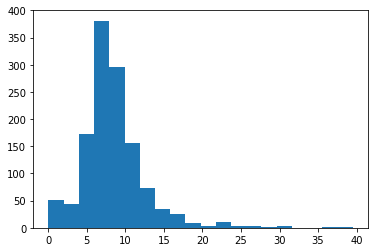



count    1270.000000
mean        8.496204
std         4.226131
min         0.024059
25%         6.216631
50%         7.815732
75%         9.988043
max        39.505580
dtype: float64


In [929]:
#1.5 Total Factor Productivity estimates--CD version just for comparison

Y=df_14['Y']

K=df_14['K']
L=df_14['L']
M=df_14['M']

#Using OLS with dummy variables included production function estimates
a=ols2.params[1]
b=ols2.params[2]
r=ols2.params[3]

A = Y/(K**a*L**b*M**r)

plt.hist(A,20) # The second argument sets the number of bins
plt.show()
print('\n')
print(A.describe(percentiles=[0.25, 0.50, 0.75]))

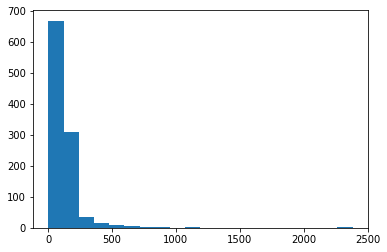



count    1046.000000
mean      125.301778
std       123.469696
min         2.145345
25%        71.390076
50%       102.245647
75%       139.900412
max      2382.779658
dtype: float64


In [933]:
#1.5 Total Factor Productivity estimates--VA version --> The Production Estimate I Selected

VA=df_1314['VA14']

K=df_1314['K14']
L=df_1314['L14']

#Using Proxy Variable production function estimates
alpha_hat = ols6.params[1]
beta_hat = ols5.params[0]
#Total factor productivity estimates using Proxy Variable production function estimates
A1 = VA/(K**alpha_hat*L**beta_hat)

plt.hist(A1,20) # The second argument sets the number of bins
plt.show()
print('\n')
print(A1.describe(percentiles=[0.25, 0.50, 0.75]))


1.5Q: Interpret this ratio.

A: Total factor productivity in 2014

In [950]:
#1.6 Productivity decomposition

VA = df_1314['VA14']
S = VA/np.mean(VA)

ols7=sm.OLS(S, A1).fit(cov_type="HC0")
ols7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   VA14   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     26.36
Date:                Fri, 09 Mar 2018   Prob (F-statistic):           3.38e-07
Time:                        16:00:23   Log-Likelihood:                -2525.4
No. Observations:                1046   AIC:                             5053.
Df Residuals:                    1045   BIC:                             5058.
Df Model:                           1                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0103      0.002      5.134      0.000       0.006       0.014
==============================================================================
Omnibus:                     1328.601   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           214943.038
Skew:                           6.579   Prob(JB):                         0.00
Kurtosis:                      71.983   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

1.6Q: Let ${S}_t = {Y}_t/E[{Y}_t]$
Show that $E[{S}_t{A}_t] = E[{S}_t]E[{A}_t]+C({S}_t,{A}_t)$ 
                         = $E[{A}_t]$+${\beta}$$V({A}_t)$,
                          
                          
where ${\beta}$ is the coefficient on ${A}_t$ in the best linear predictor of ${S}_t$ onto ${A}_t$. Interpret this decomposition

Ans: Since $C({S}_t,{A}_t) = E[{S}_t{A}_t] - E[{S}_t]E[{A}_t]$,
we have the first identity hold when we move the term $E[{S}_t]E[{A}_t]$ over to the left hand side and switch the sides.
Then, since $E[{S}_t] = E[{Y}_t/E[{Y}_t]] = E[{Y}_t]/E[{Y}_t] = 1$, we have $E[{S}_t]E[{A}_t]=E[{A}_t]$

Also, since ${\beta}$ = $C({S}_t,{A}_t)$/$V({A}_t)$, we have $C({S}_t,{A}_t)$ = ${\beta}$$V({A}_t)$

Thus, $E[{S}_t]E[{A}_t]+C({S}_t,{A}_t)$ = $E[{A}_t]$+${\beta}$$V({A}_t)$,
and we have shown the second identity

Now to interpret this decomposition, we can see $E[{S}_t{A}_t] = E[{A}_t] + C[{S}_t,{A}_t]$ first. Here, ${S}_t$ gives the relative firm size by sale, and we see how the average relative productivity of firms of different sizes is determined by adding covariance of S and ${A}_t$ to the the average productivity of all firms. For example, if the covariance is zero, then we get $E[{S}_t{A}_t]$ = $E[{A}_t]$, meaning we get the same average productivity regardless of the firm size, since firm size and productivity are not correlated. Lastly, if we believe $C[{S}_t,{A}_t]$ is positive, then the average relative productivity among larger firms will be greater than the average productivity of all firms.


In [951]:
#1.6 Calculate estimates of its two terms for 2014
E_A = np.mean(A1)
beta = ols7.params[0]
V_A = np.var(A1)

print(E_A)
print('\n')
print(beta*V_A)

125.30177772530027


157.145276883


1.7 Wrap up

Q: Write 3 or 4 paragraphs summarizing analysis of this dataset.

A:
As much as firms are interested in measuring productivity, productivity measurement is a challenging task facing economists and policymakers. Since 1980's with increase in market competition, questions on productivity change have become more relevant, since they would determine the level of inequality in the market deriving from the gap of technology and skill.

In this exercise we have analyzed three different ways to estimate firm's productivity. 
First, we adopted Cobb-Douglas production function form of $Y=A{K}^\alpha{L}^\beta{M}^\gamma$ and took the log of both sides to run a simple OLS regression of logY on $logK$, $logL$, and $logM$. Using the data of observed input variables like labor, capital, and materials expenditures, we were then able to obtain estimates for elasticities of output with respect to capital, labor, and materials expenditures. In the second part, we added sector specific dummy variables to our previous OLS regression, thus fixing industry-specific variables. Based on the regression statistics obtained, we then performed hypothesis testing for constant returns to scale, conclduing that under 95% confidence level we reject the null hypothesis of constant returns to scale in both regressions.

Then, we used "first differenced" approach, keeping the production function the same. For this analysis, we had to make an assumption of constant elasticity of product with respect to input variables in addition to the exogeneity assumption. The goal of this approach would be to eliminate effect of unobserved variables that remain constant over time from our analysis since that might potentially bias our estimates. In both panel data regression and panel data regression with dummy variables, we were not able to reject the null hypothesis of constant returns to scale.

OLS and "first differenced" approaches seem to rely on stronger general econometric assumptions than the proxy variable approach. Before in OLS and panel data approaches, productivity is assumed to be uncorrelated with capital and labor, either in level terms or growth rate terms. On the other hand, the proxy variable approach adopts stronger assumptions on the economic nature of the firm's production functions. Here, productivity is given as a function of capital and investments that are slowly adjustable, while labor is rather more promptly adjusted. If these assumptions reflect the true nature of firms and market conditions, then our estimates would be closer to unbiased.

Finally, we obtain total factor productivity estimates using one of the approaches mentioned above. The measure and distribution of productivity estimates vary significantly, depending on the methodology chosen. Depending on the firm size, we can decompose the average relative productivity into the average productivity and the covariance between the relative size and the productivity.